# Instalation for Conda and PIP3

In [1]:
# !conda install -c anaconda pandas -y
# !conda install -c anaconda fse -y
# !conda install -c conda-forge matplotlib -y
# !pip3 install fse
# !pip3 install pytorch-nlp
# !pip3 install nltk

# Import : Dependency

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import re
import string
import collections
import fse
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchnlp.metrics import get_moses_multi_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

import nltk
nltk.download('punkt')

# Any results you write to the current directory are saved as output.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nurrizkyimani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Path: Local Path for taking the data

In [4]:
all_agree_path = "2022_thesis_styletransfer/annotated/combined/csv/all_agree.csv"
all_agree_pd = pd.read_csv(all_agree_path)
df_clickbait = all_agree_pd[all_agree_pd['label'] == "clickbait"]
df_nonclickbait = all_agree_pd[all_agree_pd['label'] == "non-clickbait"]
#creating a concatination of both df cickbait and nonclickbait
df_both = pd.concat((df_clickbait, df_nonclickbait), ignore_index=True)
df_both.head(-2)

df_both_l = df_both.copy()
df_both_l['label'] = df_both_l['label'].astype('category')
df_both_l.head(-1)

,title,label,label_score
0,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
1,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",clickbait,1
2,Pesan Gamblang Poyuono Menolak Revisi UU KPK,clickbait,1
3,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,clickbait,1
4,"Viral Video Diduga Baku Tembak di Sleman, Ini ...",clickbait,1
...,...,...,...
8607,"Smart SIM Diluncurkan, Wakapolri Harap Bisa Me...",non-clickbait,0
8608,"Wamena Papua Kembali Membara, Kantor Bupati Di...",non-clickbait,0
8609,BMKG Angkat Bicara Soal Langit Merah Jambi,non-clickbait,0
8610,Operasional Bandara Wamena Dihentikan Akibat R...,non-clickbait,0


In [5]:
df_both_label = df_both_l.drop('label_score', axis=1)
df_both = df_both_l.drop('label', axis=1)
df_both.head(-5)

,title,label_score
0,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,1
1,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",1
2,Pesan Gamblang Poyuono Menolak Revisi UU KPK,1
3,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,1
4,"Viral Video Diduga Baku Tembak di Sleman, Ini ...",1
...,...,...
8603,Komnas HAM Minta Aparat Keamanan Tak Gunakan K...,0
8604,Mahasiswa Minta TNI Turun Bersama Kawal Aksi D...,0
8605,Polisi Pulangkan 56 Mahasiswa Setelah Sempat D...,0
8606,KPK Tepis Tudingan Moeldoko Soal Hambat Investasi,0


In [6]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df_both_l['label_encoding'] = labelencoder.fit_transform(df_both_l['label'])

df_encode_clean = df_both_l.copy()
df_encode_clean = df_both = df_both_l.drop(['label_score'], axis=1)
df_encode_clean.head()

,title,label,label_encoding
0,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,0
1,"Ada Motor Nyangkut di Atas Bambu di Sleman, Ko...",clickbait,0
2,Pesan Gamblang Poyuono Menolak Revisi UU KPK,clickbait,0
3,Kocak! Maling di Rumah Mewah Jakut Terekam CCT...,clickbait,0
4,"Viral Video Diduga Baku Tembak di Sleman, Ini ...",clickbait,0


# Preprocessing: lower casing

In [7]:
# preprocessing : lower casing
df_encode_clean['title'] = df_encode_clean['title'].str.lower()
df_encode_clean.title

0       viral! driver ojol di bekasi antar pesanan mak...
1       ada motor nyangkut di atas bambu di sleman, ko...
2            pesan gamblang poyuono menolak revisi uu kpk
3       kocak! maling di rumah mewah jakut terekam cct...
4       viral video diduga baku tembak di sleman, ini ...
                              ...                        
8608    wamena papua kembali membara, kantor bupati di...
8609           bmkg angkat bicara soal langit merah jambi
8610    operasional bandara wamena dihentikan akibat r...
8611     asap karhutla riau mulai merambah ke nias, bm...
8612    tolak ruu pertanahan, ribuan petani siap gelar...
Name: title, Length: 8613, dtype: object

In [8]:
df_encode_clean_t =  df_encode_clean.copy()
df_encode_clean_t['title'] = df_encode_clean_t['title'].apply(lambda y: " ".join((re.sub(r'([!/?/./,/%/\'/\"/-/:])', lambda x: ' ' + x.group()+' ' , y)).split()) , 1)
df_encode_clean_t

,title,label,label_encoding
0,viral ! driver ojol di bekasi antar pesanan ma...,clickbait,0
1,"ada motor nyangkut di atas bambu di sleman , k...",clickbait,0
2,pesan gamblang poyuono menolak revisi uu kpk,clickbait,0
3,kocak ! maling di rumah mewah jakut terekam cc...,clickbait,0
4,"viral video diduga baku tembak di sleman , ini...",clickbait,0
...,...,...,...
8608,"wamena papua kembali membara , kantor bupati d...",non-clickbait,1
8609,bmkg angkat bicara soal langit merah jambi,non-clickbait,1
8610,operasional bandara wamena dihentikan akibat r...,non-clickbait,1
8611,"asap karhutla riau mulai merambah ke nias , bm...",non-clickbait,1


create a space between the punctuation, DO NOT RUN TWICE

preprocessing: split between clickbait and nonclickbait

In [9]:
df_clickbait_clean = df_encode_clean_t[df_encode_clean_t['label'] == "clickbait"]
df_nonclickbait_clean = df_encode_clean_t[df_encode_clean_t['label'] == "non-clickbait"]

make the df into a list only in clickbait and nonclickbait

In [10]:
import itertools
d_both = pd.concat((df_clickbait_clean, df_nonclickbait_clean ), ignore_index=True)
d_both = d_both.drop(['label', 'label_encoding'], axis=1)
d_both = d_both.values.tolist()
d_both = list(itertools.chain.from_iterable(d_both))

In [11]:
d_both

['viral ! driver ojol di bekasi antar pesanan makanan pakai sepeda',
 'ada motor nyangkut di atas bambu di sleman , kok bisa ?',
 'pesan gamblang poyuono menolak revisi uu kpk',
 'kocak ! maling di rumah mewah jakut terekam cctv bingung cari jalan kabur',
 'viral video diduga baku tembak di sleman , ini kata polisi',
 'waspada ! ada penipuan catut pertamina , korbannya rugi puluhan juta',
 'jaksa beberkan senpi-peluru tajam pembelian kivlan zen cs , ini rinciannya',
 'sering quality time bersama keluarga ? ternyata ini 3 manfaatnya !',
 'menteri jokowi 55 % profesional , ini kandidatnya ?',
 "pria misterius berjubah putih viral di sumut , ingatkan ' tuhan murka '",
 'video porno di sumedang disebar pemeran pria , apa motifnya ?',
 'terungkap ! video porno di sumedang diperankan pasangan selingkuh',
 'kendaraan listrik bebas dari aturan ganjil-genap , ini alasannya',
 'menanti " kebijakan gila " jokowi',
 'akhirnya ! pemkot pekanbaru liburkan sd dan smp karena kabut asap',
 '2 ribu hekt

In [12]:
# make the df into a list only in clickbait and nonclickbait

df_clickbait_t = df_clickbait_clean.drop(['label', 'label_encoding'], axis=1).values.tolist()
clickbait_l_c = list(itertools.chain.from_iterable(df_clickbait_t))

df_nonclickbait_t = df_nonclickbait_clean.drop(['label', 'label_encoding'], axis=1).values.tolist()
nonclickbait_l_c = list(itertools.chain.from_iterable(df_nonclickbait_t))

print(nonclickbait_l_c[0:5])
print(clickbait_l_c[0:5])

['masuk radar pilwalkot medan , menantu jokowi bertemu dpw nasdem sumut', 'malaysia sudutkan ri : isu kabut asap hingga invasi babi', 'kemensos salurkan rp 7 , 3 m bagi korban kerusuhan sosial di papua', 'mpr : amandemen uud 1945 tak akan melebar ke mana-mana', 'peringati tahun baru islam , banyuwangi kembali gelar festival muharam']
['viral ! driver ojol di bekasi antar pesanan makanan pakai sepeda', 'ada motor nyangkut di atas bambu di sleman , kok bisa ?', 'pesan gamblang poyuono menolak revisi uu kpk', 'kocak ! maling di rumah mewah jakut terekam cctv bingung cari jalan kabur', 'viral video diduga baku tembak di sleman , ini kata polisi']


Creating the iterators and split training, test, and validation

In [13]:
# end result : list
nonclickbait_l_c
clickbait_l_c

['viral ! driver ojol di bekasi antar pesanan makanan pakai sepeda',
 'ada motor nyangkut di atas bambu di sleman , kok bisa ?',
 'pesan gamblang poyuono menolak revisi uu kpk',
 'kocak ! maling di rumah mewah jakut terekam cctv bingung cari jalan kabur',
 'viral video diduga baku tembak di sleman , ini kata polisi',
 'waspada ! ada penipuan catut pertamina , korbannya rugi puluhan juta',
 'jaksa beberkan senpi-peluru tajam pembelian kivlan zen cs , ini rinciannya',
 'sering quality time bersama keluarga ? ternyata ini 3 manfaatnya !',
 'menteri jokowi 55 % profesional , ini kandidatnya ?',
 "pria misterius berjubah putih viral di sumut , ingatkan ' tuhan murka '",
 'video porno di sumedang disebar pemeran pria , apa motifnya ?',
 'terungkap ! video porno di sumedang diperankan pasangan selingkuh',
 'kendaraan listrik bebas dari aturan ganjil-genap , ini alasannya',
 'menanti " kebijakan gila " jokowi',
 'akhirnya ! pemkot pekanbaru liburkan sd dan smp karena kabut asap',
 '2 ribu hekt

# Ngram : Delete, get attribute and content section

In [14]:
#Parameters:
param_smooth = 1
param_threshold = 5
param_span = 4

param_backoff_limit = 3

#ngram has punctuation
def has_punctuation(ngram): #damn I'm very proud of making this from scratch lol, looks elegant in one line
    return True in [x in string.punctuation for x in ngram]

# generate ngram from all of the sentence
def generate_ngrams(lines,  min_length: int =1, max_length=param_span) -> dict :
    #     lines = placeholder + lines
    lengths: range  = range(min_length, max_length + 1)
    ngrams: dict  = {length: [] for length in lengths}
    queue: collections.deque = collections.deque(maxlen=max_length)

    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length and not has_punctuation(current[:length]):
                ngrams[length].append(current[:length])

    short_by = 0
    for line in lines:
        short_by = max(0, max_length - len(lines))
        for word in line.split():
            queue.append(word)
            if len(queue) >= max_length-short_by:
                add_queue()

    while len(queue) > min_length:
        queue.popleft()
        add_queue()
    return ngrams

#modified from & fixed their error of ngram with # of words < 4: https://gist.github.com/benhoyt/dfafeab26d7c02a52ed17b6229f0cb52
def count_ngrams(lines, min_length: int =1, max_length=param_span ) -> dict:
    """Iterate through given lines iterator (file object or list of
    lines) and return n-gram frequencies. The return value is a dict
    mapping the length of the n-gram to a collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length and not has_punctuation(current[:length]):
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    short_by = 0
    for line in lines:
        short_by = max(0, max_length - len(lines))
        for word in line.split():
            queue.append(word)
            if len(queue) >= max_length - short_by:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams


In [15]:
# EXAMPLE : generate ngram without any counting; just generate ngram
test = generate_ngrams(clickbait_l_c)
test

{1: [('viral',),
  ('driver',),
  ('ojol',),
  ('di',),
  ('bekasi',),
  ('antar',),
  ('pesanan',),
  ('makanan',),
  ('pakai',),
  ('sepeda',),
  ('ada',),
  ('motor',),
  ('nyangkut',),
  ('di',),
  ('atas',),
  ('bambu',),
  ('di',),
  ('sleman',),
  ('kok',),
  ('bisa',),
  ('pesan',),
  ('gamblang',),
  ('poyuono',),
  ('menolak',),
  ('revisi',),
  ('uu',),
  ('kpk',),
  ('kocak',),
  ('maling',),
  ('di',),
  ('rumah',),
  ('mewah',),
  ('jakut',),
  ('terekam',),
  ('cctv',),
  ('bingung',),
  ('cari',),
  ('jalan',),
  ('kabur',),
  ('viral',),
  ('video',),
  ('diduga',),
  ('baku',),
  ('tembak',),
  ('di',),
  ('sleman',),
  ('ini',),
  ('kata',),
  ('polisi',),
  ('waspada',),
  ('ada',),
  ('penipuan',),
  ('catut',),
  ('pertamina',),
  ('korbannya',),
  ('rugi',),
  ('puluhan',),
  ('juta',),
  ('jaksa',),
  ('beberkan',),
  ('senpi-peluru',),
  ('tajam',),
  ('pembelian',),
  ('kivlan',),
  ('zen',),
  ('cs',),
  ('ini',),
  ('rinciannya',),
  ('sering',),
  ('quality

In [16]:
#Example of usage: count ngram of the list of sentence
d_nonclick_ngrams_counts = count_ngrams(nonclickbait_l_c)
d_clickbait_ngrams_counts = count_ngrams(clickbait_l_c)
d_nonclick_ngrams_counts

{1: Counter({('masuk',): 35,
          ('radar',): 1,
          ('pilwalkot',): 5,
          ('medan',): 19,
          ('menantu',): 2,
          ('jokowi',): 174,
          ('bertemu',): 22,
          ('dpw',): 1,
          ('nasdem',): 5,
          ('sumut',): 20,
          ('malaysia',): 44,
          ('sudutkan',): 1,
          ('ri',): 39,
          ('isu',): 6,
          ('kabut',): 113,
          ('asap',): 163,
          ('hingga',): 77,
          ('invasi',): 1,
          ('babi',): 2,
          ('kemensos',): 2,
          ('salurkan',): 16,
          ('rp',): 94,
          ('7',): 32,
          ('3',): 88,
          ('m',): 42,
          ('bagi',): 27,
          ('korban',): 61,
          ('kerusuhan',): 16,
          ('sosial',): 7,
          ('di',): 1348,
          ('papua',): 130,
          ('mpr',): 15,
          ('amandemen',): 1,
          ('uud',): 3,
          ('1945',): 1,
          ('tak',): 218,
          ('akan',): 174,
          ('melebar',): 1,
          ('ke',

In [17]:
#these are methods that will become useful when extracting attribute markers
#why do we need all this? well... that's like 5 hours of debugging...
def flatten(foo):
    return list(_flatten(foo))

def _flatten(foo):
    for x in foo:
        if isinstance(x, collections.Iterable) and not isinstance(x, str):
            for y in _flatten(x):
                yield y
        else:
            yield x

def array_to_string(a):
    return ' '.join(flatten(a))

def is_in_string_array(elements, original): #deprecated, does not take into account sequence order
    return np.isin(array_to_string(elements).split(), array_to_string(original).split()).any()

# no usage in the func
def insert_string(string, inserted_string, index):
    return string[:index] + inserted_string + string[index:]

# modified from https://stackoverflow.com/questions/41752946/replacing-a-character-from-a-certain-index
def replace_string(s, newstring, index, nofail=False):
    # raise an error if index is outside of the string
    if not nofail and index not in range(len(s)):
        raise ValueError("index outside given string. index:" + index)

    # if not erroring, but the index is still not in the correct range..
    if index < 0:  # add it to the beginning
        return newstring + s
    if index > len(s):  # add it to the end
        return s + newstring

    # insert the new string between "slices" of the original
    return s[:index] + newstring + s[index + len(newstring):]

Get attribute marker, content

In [18]:
# get the ngram count based on the reference sentence onlhy
def get_counts(list1, counted_ngrams):
    counts = []
    list1_ngrams = generate_ngrams(list1)
    list2_counts = counted_ngrams

    for length in range(param_span,0, -1):
        for v in list1_ngrams[length]:
            counts.append([list2_counts[length][v], v])
    return np.array(counts)

def get_attribute_markers(s, style_src):
    sentence = [s]

    ngrams = get_counts(sentence, d_nonclick_ngrams_counts)
    if len(ngrams) > 0:
        ngrams = ngrams[:,1]

    pos_counts = get_counts(sentence, d_nonclick_ngrams_counts)
    if len(pos_counts) > 0:
        pos_counts = pos_counts[:,0]

    neg_counts = get_counts(sentence, d_clickbait_ngrams_counts)
    if len(neg_counts) > 0:
        neg_counts = neg_counts[:,0]


    if(style_src):
        importances = (pos_counts + param_smooth) / (neg_counts + param_smooth)
    else:
        importances = (neg_counts + param_smooth) / (pos_counts + param_smooth)

    a = []

    importances = np.vstack((importances, ngrams)).T
    for importance in importances:
        if importance[0] > param_threshold and not is_in_string_array(importance[1], a):
            a.append(' '.join(importance[1]))
    return a

def separate(sentence, style_src):
    attributes = get_attribute_markers(sentence, style_src)
    c = sentence

    replace_indexes = []
    for a in attributes:
        replace_index = -1
        replace_index = c.find(a)
        replace_indexes.append(replace_index)
        c = c.replace(a, " "*len(a))

    if len(attributes) == 0:
        return {'c': c, 'a': [], 'i': [], 's': sentence}

    replace_indexes, attributes = zip(*sorted(zip(replace_indexes, attributes)))
    return {'c': c, 'a': attributes, 'i': replace_indexes, 's': sentence}

def get_c(sentence, style):
    return re.sub(' +', ' ', separate(sentence, style)['c'])

def get_a(sentence, style):
    a = separate(sentence, style)['a']
    if len(a) > 0:
        return ' '.join(a)
    else:
        return ""

# TFIDF : Get similar sentence

In [19]:
# ===== TF-IDF Weighted Word Overlap ===== #
# docs pre-processing
# docs = d_both.values.tolist()
# d_pos = nonlickbait
# d_neg = clickbait
# d_pos = nonclickbait_l_c
docs = d_both

d_pos = nonclickbait_l_c
d_neg = clickbait_l_c

# creating dict_idf = {word: idf}
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(use_idf=True, stop_words=None)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)
dict_idf = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer.idf_))

def get_overlap(a, b):
    #     print(a, b)
    a_counter = collections.Counter(a.split())
    b_counter = collections.Counter(b.split())
    overlap = a_counter & b_counter
    return overlap

def get_weighted_overlap(a, b):
    overlap = get_overlap(a, b)
    a_counter = collections.Counter(a.split())
    #calculate
    weighted_overlap = 0
    for word in overlap:

        word_tf = a_counter[word]#/len(a.split()) -> commented out cause division by constant value doesn't matter

        get_idf = dict_idf.get(word)
        word_idf = 1 if get_idf == None else get_idf #get rid of error when idf not in dict

        word_tfidf = word_tf*word_idf
        weighted_overlap+=overlap[word]*word_tfidf

    return weighted_overlap

def get_closest_sentence_tfidf(sentence, style_src):
    opposite_dataset = d_neg if style_src else d_pos

    highest_overlap = 0
    closest_sentence = ""

    min_attribute_markers=len(get_attribute_markers(sentence, style_src))
    num_markers = 0

    previous_sentences = []
    backoff_count = 0
    while(num_markers < min_attribute_markers and backoff_count < param_backoff_limit):
        for sentence_b in opposite_dataset:
            weighted_overlap = get_weighted_overlap(sentence, sentence_b)
            if weighted_overlap > highest_overlap and sentence_b not in previous_sentences:
                highest_overlap = weighted_overlap
                closest_sentence = sentence_b
        highest_overlap = 0
        backoff_count += 1
        previous_sentences.append(closest_sentence)
        num_markers = len(get_attribute_markers(closest_sentence, not style_src))

    return closest_sentence

/Users/nurrizkyimani/.conda/envs/workspace/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [20]:
# Retrieve using tfidf
def retrieve(sentence, style_src):
    return separate(get_closest_sentence_tfidf(sentence, style_src), not style_src)

In [21]:
stc_test_retrieve = "kocak ! maling di rumah mewah jakut terekam cctv bingung cari jalan kabur"
test_retrive = retrieve(stc_test_retrieve, 1)

print(test_retrive)

{'c': '', 'a': [], 'i': [], 's': ''}


/var/folders/1n/2gdy6g815s301ygx2s35p6_80000gp/T/ipykernel_68928/1388602369.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(counts)


In [22]:
stc_test_retrieve = random.choice(nonclickbait_l_c)
print("x sentence: {} ".format(stc_test_retrieve))
stc_res = get_closest_sentence_tfidf(stc_test_retrieve, 1)
print("y sentence: {} ".format(stc_res))

x sentence: pemerintah menang rebutan wewenang mengangkat dewan pengawas kpk 
y sentence: capim kpk lili pintauli : saya tidak setuju dewan pengawas 


/var/folders/1n/2gdy6g815s301ygx2s35p6_80000gp/T/ipykernel_68928/1388602369.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(counts)
/var/folders/1n/2gdy6g815s301ygx2s35p6_80000gp/T/ipykernel_68928/3294799954.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(x, collections.Iterable) and not isinstance(x, str):


# Input Dict: Creating the lang dictionary, NN Preprocess; Training Prep

In [23]:
# Resources: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# Had to modify & adapt most of the code in the tutorial since this isn't translation & data preprocessing is different

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [24]:
# count the overlap; we need function for this;
def get_overlap(a, b):
    # print(a, b)
    a_counter = collections.Counter(a.split())
    # print(a_counter)
    b_counter = collections.Counter(b.split())
    overlap = a_counter & b_counter
    return overlap

def get_total_overlap(a, b):
    return len(list(get_overlap(a, b).elements()))

In [25]:
noise_chance = 0.1

def prepareData():
    input_lang = Lang("input")
    output_lang = Lang("output")

    d_pos_a = []

    pairs_pos = []
    for sentence in nonclickbait_l_c:
        c = get_c(sentence, 1)
        a = get_a(sentence, 1)
        d_pos_a.append(a)
        pairs_pos.append([c, a, sentence])

    d_neg_a = []

    pairs_neg = []
    for sentence in clickbait_l_c:
        c = get_c(sentence, 0)
        a = get_a(sentence, 0)
        d_neg_a.append(a)
        pairs_neg.append([c, a, sentence])

    #adding noise for pos
    for pair in pairs_pos:
        if random.random() < noise_chance:
            real_a = pair[1].split()

            if(len(real_a) == 0):
                continue

            for a in d_pos_a:
                if(len(a) == 0):
                    continue
                a = a.split()

                overlap = get_total_overlap(' '.join(real_a), ' '.join(a))
                if overlap > 0 and ((overlap == len(real_a) - 1 and len(real_a) - len(a) == 1) or (overlap == len(real_a) and len(real_a) - len(a) == -1)):
                    real_a = a
                    break;
            pair[1] = ' '.join(real_a)


    #adding noise for neg
    for pair in pairs_neg:
        if random.random() < noise_chance:
            real_a = pair[1].split()
            if(len(real_a) == 0):
                continue

            for a in d_neg_a:
                if(len(a) == 0):
                    continue
                a = a.split()

                overlap = get_total_overlap(' '.join(real_a), ' '.join(a))
                if overlap > 0 and ((overlap == len(real_a) - 1 and len(real_a) - len(a) == 1) or (overlap == len(real_a) and len(real_a) - len(a) == -1)):
                    real_a = a
                    break;
            pair[1] = ' '.join(real_a)

    #concat atas bawah;
    pairs = np.concatenate((pairs_pos, pairs_neg), 0)

    for pair in pairs:

        input_lang.addSentence(pair[0])

        input_lang.addSentence(pair[1])
        # sentence full
        output_lang.addSentence(pair[2])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

get the input_dict, output_dict, and pairs ()

In [26]:
input_lang, output_lang, pairs = prepareData()

/var/folders/1n/2gdy6g815s301ygx2s35p6_80000gp/T/ipykernel_68928/1388602369.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(counts)


Counted words:
input 13961
output 13896


In [27]:
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
for pair in pairs:
    input_lang.addSentence(pair[1])
    output_lang.addSentence(pair[0])

In [28]:
print("Counted words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)

Counted words:
input 13961
output 13984


In [29]:
pairs.dtype

dtype('<U120')

# Dataset:  Train, Validation, Test Split

In [30]:
from torch.utils.data import Subset

def train_val_dataset(dataset, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [31]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(pairs, test_size=0.3, random_state=42)

In [32]:
from sklearn.model_selection import train_test_split

train_data, test_data  = train_test_split(pairs, test_size=0.2, random_state=42)
train_data, validation_data = train_test_split(train_data, test_size=0.18, random_state=42)

In [33]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of testing examples: {len(test_data)}")
print(f"Number of validation examples: {len(validation_data)}")

Number of training examples: 5649
Number of testing examples: 1723
Number of validation examples: 1241


In [34]:
print(f"{train_data[0]} => {train_data[0]} ")
print(test_data[0])
print(validation_data[0])

['tak perlu ke lombok-bali , gili di jawa timur yang memikat' 'inilah'
 'tak perlu ke lombok-bali , inilah gili di jawa timur yang memikat'] => ['tak perlu ke lombok-bali , gili di jawa timur yang memikat' 'inilah'
 'tak perlu ke lombok-bali , inilah gili di jawa timur yang memikat'] 
[' europa : 0-3' 'hasil liga eintracht frankfurt vs arsenal'
 'hasil liga europa : eintracht frankfurt vs arsenal 0-3']
['hotel akan tampung warga kebakaran hutan' 'riau terkena dampak'
 'hotel riau akan tampung warga terkena dampak kebakaran hutan']


# Neural Network: Encoder Decoder

In [35]:
class Maxout(nn.Module):
    def __init__(self, pool_size):
        super().__init__()
        self._pool_size = pool_size

    def forward(self, x):
        assert x.shape[1] % self._pool_size == 0, \
            'Wrong input last dim size ({}) for Maxout({})'.format(x.shape[1], self._pool_size)
        m, i = x.view(*x.shape[:1], x.shape[1] // self._pool_size, self._pool_size, *x.shape[2:]).max(2)
        return m

In [36]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, word_vec_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.LSTM = nn.LSTM(word_vec_size,hidden_size, num_layers=2)

        self.embedding = nn.Embedding(input_size, word_vec_size)
        self.gru = nn.GRU(word_vec_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [37]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, word_vec_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, word_vec_size)

        # self.LSTM = nn.LSTM(word_vec_size,hidden_size, num_layers=2)

        self.gru = nn.GRU(word_vec_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.maxout = Maxout(1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = self.maxout(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [38]:
#Preparing Training Data
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_c_tensor = tensorFromSentence(input_lang, pair[0])
    input_a_tensor = tensorFromSentence(input_lang, pair[1])
    target_tensor = tensorFromSentence(output_lang, pair[2])
    return input_c_tensor, input_a_tensor, target_tensor

# Training : Training and TrainingIters

In [62]:
#Training
MAX_LENGTH = 50
teacher_forcing_ratio = 0.5

def model(input_c_tensor  ,
          input_a_tensor,
          target_tensor,
          encoder_c,
          encoder_a,
          decoder,
          encoder_c_optimizer,
          encoder_a_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH
          ):

    # init hidden
    encoder_c_hidden = encoder_c.initHidden()
    encoder_a_hidden = encoder_a.initHidden()

    # zero grad
    encoder_a_optimizer.zero_grad()
    encoder_c_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # len of sentence of c, a, t, that already; e.g input_c_length= len(input_c_tensor)
    input_c_length = input_c_tensor.size(0)
    input_a_length = input_a_tensor.size(0)
    target_length = target_tensor.size(0)


    encoder_c_outputs = torch.zeros(max_length, encoder_c.hidden_size, device=device)
    encoder_a_outputs = torch.zeros(max_length, encoder_a.hidden_size, device=device)

    loss = 0

    for ei in range(input_c_length):
        encoder_c_output, encoder_c_hidden = encoder_c(input_c_tensor[ei], encoder_c_hidden)
        encoder_c_outputs[ei] = encoder_c_output[0, 0]

    for ei in range(input_a_length):
        encoder_a_output, encoder_a_hidden = encoder_a(input_a_tensor[ei], encoder_a_hidden)
        encoder_a_outputs[ei] = encoder_a_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = torch.cat((encoder_c_hidden, encoder_a_hidden), 2)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Teacher forcing: Feed the target as the next input
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    # Without teacher forcing: use its own predictions as the next input
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_c_optimizer.step()
    encoder_a_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [83]:
criterion: nn.NLLLoss = nn.NLLLoss()

def training(
        encoder_a : EncoderRNN,
        encoder_c : EncoderRNN,
        decoder : DecoderRNN,
        n_iters : int ,
        data_pairs,
        print_every : int =1000,
        plot_every : int =10,
        learning_rate : float =0.01,
        ):

    start: float = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_c_optimizer : optim.Adadelta = optim.Adadelta(encoder_c.parameters(), lr= learning_rate)
    encoder_a_optimizer : optim.Adadelta = optim.Adadelta(encoder_a.parameters(), lr= learning_rate)
    decoder_optimizer :  optim.Adadelta = optim.Adadelta(decoder.parameters(), lr= learning_rate)

    # train iterator
    training_pairs = [tensorsFromPair(random.choice(data_pairs)) for i in range(n_iters)]
    for iter  in  range(1, n_iters + 1):
        # taking the pair and extract the c, a, target
        training_pair = training_pairs[iter - 1]
        input_tensor_c = training_pair[0]
        input_tensor_a = training_pair[1]
        target_tensor = training_pair[2]

        # outside:
            # optimizer
            # criterion
        #

        # train each of the tensors
        loss = model(

            input_tensor_c,
            input_tensor_a,
            target_tensor,

            encoder_a,
            encoder_c ,
            decoder,

            encoder_a_optimizer,
            encoder_c_optimizer,
            decoder_optimizer,

            criterion,
        )

        # get total loss and plot
        print_loss_total += loss
        plot_loss_total += loss

        # START : print and plotting every certain index
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [91]:
import time
import math
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Training: Evaluation

In [105]:
def evaluating(encoder_a, encoder_c, decoder,criterion, n_iters, data_pairs,  max_length=MAX_LENGTH, plot_every : int =10,):

    encoder_a.eval()
    encoder_c.eval()
    decoder.eval()

    plot_losses = []
    plot_loss_total = 0

    with torch.no_grad():
        training_pairs = [tensorsFromPair(random.choice(data_pairs)) for i in range(n_iters)]
        for iter  in  range(1, n_iters + 1):
            # taking the pair and extract the c, a, target
            training_pair = training_pairs[iter - 1]
            input_c_tensor = training_pair[0]
            input_a_tensor = training_pair[1]
            target_tensor = training_pair[2]

            # init hidden
            encoder_c_hidden = encoder_c.initHidden()
            encoder_a_hidden = encoder_a.initHidden()

            # len of sentence of c, a, t, that already; e.g input_c_length= len(input_c_tensor)
            input_c_length = input_c_tensor.size(0)
            input_a_length = input_a_tensor.size(0)
            target_length = target_tensor.size(0)

            loss = 0

            encoder_c_outputs = torch.zeros(max_length, encoder_c.hidden_size, device=device)
            encoder_a_outputs = torch.zeros(max_length, encoder_a.hidden_size, device=device)

            for ei in range(input_c_length):
                encoder_c_output, encoder_c_hidden = encoder_c(input_c_tensor[ei], encoder_c_hidden)
                encoder_c_outputs[ei] = encoder_c_output[0, 0]

            for ei in range(input_a_length):
                encoder_a_output, encoder_a_hidden = encoder_a(input_a_tensor[ei], encoder_a_hidden)
                encoder_a_outputs[ei] = encoder_a_output[0, 0]

            decoder_input = torch.tensor([[SOS_token]], device=device)
            decoder_hidden = torch.cat((encoder_c_hidden, encoder_a_hidden), 2)

            for di in range(target_length):
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

            l = loss.item() / target_length

            plot_loss_total += l
            plot_every = 10
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)

        torch.save(encoder_a.state_dict(), 'encoder-a-model.pt')
        torch.save(encoder_c.state_dict(), 'encoder-c-model.pt')
        torch.save(decoder.state_dict(), 'decoder-model.pt')

        showPlot(plot_losses)
        return l

# Running : Train, Evaluation Implementation

In [97]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of testing examples: {len(test_data)}")
print(f"Number of validation examples: {len(validation_data)}")

Number of training examples: 5649
Number of testing examples: 1723
Number of validation examples: 1241


In [98]:
n_iters = 1
training_pairs = [tensorsFromPair(random.choice(train_data)) for i in range(n_iters)]
print(*training_pairs, sep="\n")

(tensor([[2171],
        [  16],
        [4240],
        [ 880],
        [ 209],
        [5603],
        [6688],
        [6755],
        [6756],
        [1381],
        [  35],
        [ 789],
        [  32],
        [   1]]), tensor([[33],
        [ 1]]), tensor([[2159],
        [  16],
        [ 160],
        [ 207],
        [6736],
        [4233],
        [1377],
        [  25],
        [ 790],
        [  28],
        [   1]]))


In [108]:
#INITIATION OF THE ENCODER DECODER
# prev size
word_vec_size = 128
hidden_size = 512
# word_size map of the input and the output of the words
INPUT_DIM = input_lang.n_words # word counts
OUTPUT_DIM = output_lang.n_words # word counts
# dimension_size of embedding layers
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128

# hidden_size of the dimension that connect between input, hidden,output
HID_DIM = 512
NN_LAYERS = 2

# implementation in encoder both A and C
encoder_c = EncoderRNN(INPUT_DIM, ENC_EMB_DIM, HID_DIM).to(device)
encoder_a = EncoderRNN(INPUT_DIM, DEC_EMB_DIM, HID_DIM).to(device)

# decoder
decoder = DecoderRNN(HID_DIM + HID_DIM, word_vec_size, OUTPUT_DIM).to(device)

0m 1s (- 1m 58s) (1 1%) 9.5121
0m 1s (- 1m 29s) (2 2%) 9.4945
0m 2s (- 1m 25s) (3 3%) 9.5683
0m 3s (- 1m 20s) (4 4%) 9.5048
0m 3s (- 1m 14s) (5 5%) 9.5407
0m 4s (- 1m 16s) (6 6%) 9.5602
0m 5s (- 1m 15s) (7 7%) 9.5510
0m 6s (- 1m 13s) (8 8%) 9.5799
0m 7s (- 1m 14s) (9 9%) 9.5505
0m 8s (- 1m 12s) (10 10%) 9.5348
0m 8s (- 1m 11s) (11 11%) 9.5712
0m 9s (- 1m 10s) (12 12%) 9.5154
0m 10s (- 1m 10s) (13 13%) 9.5735
0m 11s (- 1m 9s) (14 14%) 9.5376
0m 12s (- 1m 8s) (15 15%) 9.5551
0m 12s (- 1m 6s) (16 16%) 9.5371
0m 13s (- 1m 4s) (17 17%) 9.5634
0m 13s (- 1m 3s) (18 18%) 9.5073
0m 14s (- 1m 3s) (19 19%) 9.5340
0m 15s (- 1m 1s) (20 20%) 9.5539
0m 16s (- 1m 2s) (21 21%) 9.5197
0m 17s (- 1m 1s) (22 22%) 9.5436
0m 18s (- 1m 0s) (23 23%) 9.5416
0m 18s (- 0m 59s) (24 24%) 9.5323
0m 19s (- 0m 59s) (25 25%) 9.5306
0m 20s (- 0m 58s) (26 26%) 9.5790
0m 21s (- 0m 57s) (27 27%) 9.5093
0m 22s (- 0m 56s) (28 28%) 9.5516
0m 22s (- 0m 55s) (29 28%) 9.5705
0m 23s (- 0m 54s) (30 30%) 9.5700
0m 24s (- 0m 53s) (3

9.520474751790365

<Figure size 640x480 with 0 Axes>

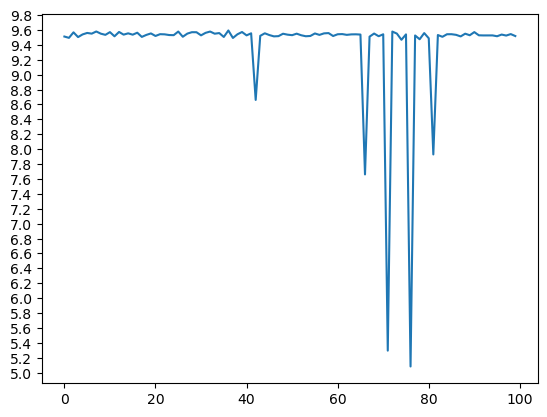

<Figure size 640x480 with 0 Axes>

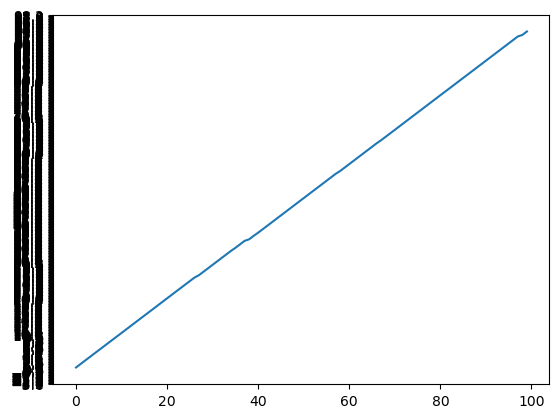

In [109]:
# Running the Training -> trainingIters() -> train() : return -> None, but new develop encoder_a, encoder_c and decoder
n_iters = 100
print_every = 1
plot_every = 1
learning_rate = 0.01

training(
    encoder_c,
    encoder_a,
    decoder,
    n_iters,
    train_data,
    print_every,
    plot_every,
    learning_rate)

evaluating(
    encoder_a,
    encoder_c,
    decoder,
    criterion,
    n_iters,
    validation_data
)

# Running: Testing

In [110]:
# # model.load_state_dict(torch.load('tut1-model.pt'))
#
# test_loss = evaluate(model, test_iterator, criterion)
#
# print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

7.947747548421224


<Figure size 640x480 with 0 Axes>

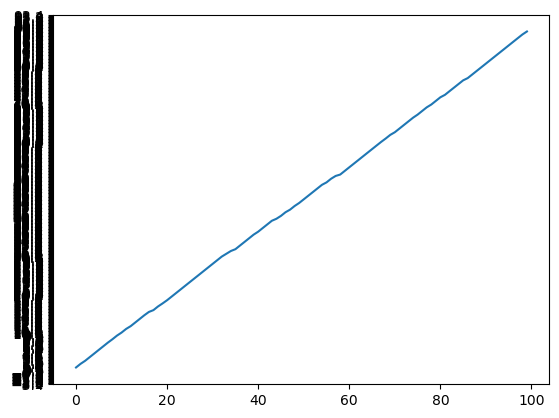

In [111]:
test = evaluating(
    encoder_a,
    encoder_c,
    decoder,
    criterion,
    n_iters,
    test_data
)

print(test)

# Prediction: Predict the Words

In [ ]:
def predictNoBeam(
        encoder_c : EncoderRNN,
        encoder_a : EncoderRNN,
        decoder : DecoderRNN,
        a: string,
        c : string,
        max_length=MAX_LENGTH):

    with torch.no_grad():
        # START: encoder from a,c
        input_tensor_c = tensorFromSentence(input_lang, c)
        input_tensor_a = tensorFromSentence(input_lang, a)

        input_length_c = input_tensor_c.size()[0]
        input_length_a = input_tensor_a.size()[0]

        encoder_hidden_c = encoder_c.initHidden()
        encoder_hidden_a = encoder_a.initHidden()

        encoder_outputs_c = torch.zeros(max_length, encoder_hidden_a.hidden_size, device=device)
        encoder_outputs_a = torch.zeros(max_length, encoder_hidden_c.hidden_size, device=device)

        for ei in range(input_length_c):
            encoder_output_c, encoder_hidden_c = encoder_c(input_tensor_c[ei], encoder_hidden_c )
            encoder_outputs_c[ei] += encoder_output_c[0, 0]

        for ei in range(input_length_a):
            encoder_output_a, encoder_hidden_a = encoder_a(input_tensor_a[ei], encoder_hidden_a)
            encoder_outputs_a[ei] += encoder_output_a[0, 0]

        enc_step = torch.cat((encoder_hidden_c, encoder_hidden_a), 2)

        decoder_hidden = torch.cat((encoder_hidden_a, encoder_hidden_c), 2)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden)

            topv, topi =  F.softmax(decoder_output).data.topk(1)

            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

In [ ]:
def predictRandomly(encoder_c, encoder_a, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = predictNoBeam(encoder_c, encoder_a, decoder, pair[0], pair[1])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# evaluateNoBeam(encoder_c, encoder_a, decoder, )